# Independent Experiment Analysis
## Treats each row as its own experiment and analyzes each row independently

In [1]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data
from helpers import *
from drift_file_io import drift_input, calculate_average_timestep, merge_lines, experiment_per_line
#################################################################################################################
#For reading in experimental data: enter here
base = "N:/Programs/Ions Share/Gate-Set Tomography/DriftAnalysis/"
name = '2018_08_27 Gi Data/2018_08_27_1627_08_DRIFT'
file_loc = base + name + ".txt"
time_per_sample = 1/60 #seconds, only necessary if you're doing the manual entry
savepath = None
save = False
if save:
    savepath = base + name + "_Independent_Experiments" + ".png"
    
time_per_sample = 1/60 #seconds

experiments = experiment_per_line(file_loc, time_per_sample)###Currently reading each line as an experiment
num_experiments = len(experiments)
results_list = []
plots_list = []
data_lists = []
top_freqs = []
top_freqs_occurence = []
nSamples = 0
##############################################################################################################
#Don't change anything below this line for regular program operation

for exp_index in range(num_experiments):
    #Initialize arrays of one-counts per timestep, zero-counts per timstep, the actual timesteps for each, and the probability of getting a 1 for each
    ones_count_array = []
    zeros_count_array = []
    timestamp_array = [] #time in seconds
    ones_count_array, zeros_count_array, timestamp_array = experiments[exp_index]
    nSamples = len(ones_count_array)
    exp_data = ()
    
    counts_per_timestep = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
    drifted = drift.do_basic_drift_characterization(ones_count_array, counts=counts_per_timestep, timestep=time_per_sample,timestamps=timestamp_array, verbosity = 0)
    results_list.append(drifted)
    
    #analyze the frequency-power spectrum
    frequencies = list(drifted.frequencies)
    power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
    grouped = []
    for i in range(len(frequencies)):
        grouped.append((frequencies[i], power_spectrum[i]))
    sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
    num_points = 5
    for i in range(num_points):
        exp_data = exp_data + ("#{}: {:.3f} Hz".format(i+1, sorted_groups[i][0]),)
        if i == 0:
            top_freqs.append(sorted_groups[i][0])
    data_lists.append(exp_data)

C:\Users\GA28573\Documents\pyGSTi-master\packages\pygsti\tools\matrixtools.py:23: UserWarning: Could not import Cython extension - falling back to slower pure-python routines
  _warnings.warn("Could not import Cython extension - falling back to slower pure-python routines")


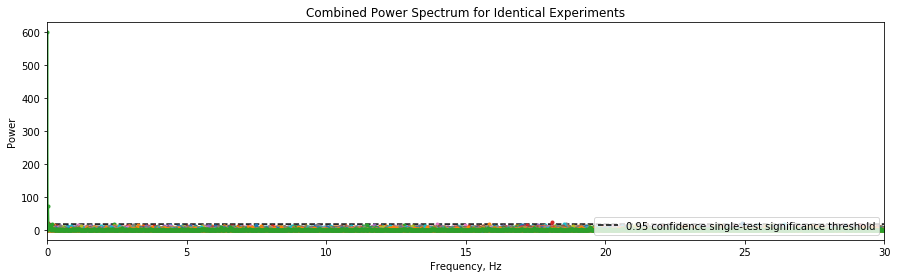

In [2]:
########### Plot the power spectra of all the experiments on the same graph

confidence_is_plotted = False

fig = plt.figure(figsize=(15,4))
for results in results_list:
    plt.plot(results.frequencies,results.pspepo_power_spectrum[0,0,1,:],ls="solid",marker='.')
    if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
    confidence_is_plotted = True
plt.legend(loc="lower right")
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((0,results_list[0].frequencies[-1]))
plt.title("Combined Power Spectrum for Identical Experiments")
if save: plt.savefig(base  + name + "_Independent_Experiments" + ".png")
plt.show()

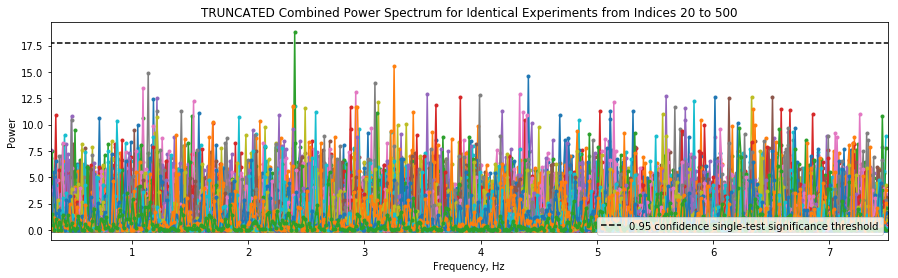

In [3]:
############################ Use this cell to truncate the plot above to see certain frequencies
confidence_is_plotted = False
mindex = 20
maxdex = 500

fig = plt.figure(figsize=(15,4))
for results in results_list:
    plt.plot(results.frequencies[mindex:maxdex],results.pspepo_power_spectrum[0,0,1,:][mindex:maxdex],ls="solid",marker='.')
    if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
    confidence_is_plotted = True
plt.legend(loc="lower right")
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((results_list[0].frequencies[mindex],results_list[0].frequencies[maxdex]))
plt.title("TRUNCATED Combined Power Spectrum for Identical Experiments from Indices {} to {}".format(mindex, maxdex))
plt.show()

!!!!!! Power is averaged here! Previous saved versions just have the powers summed!


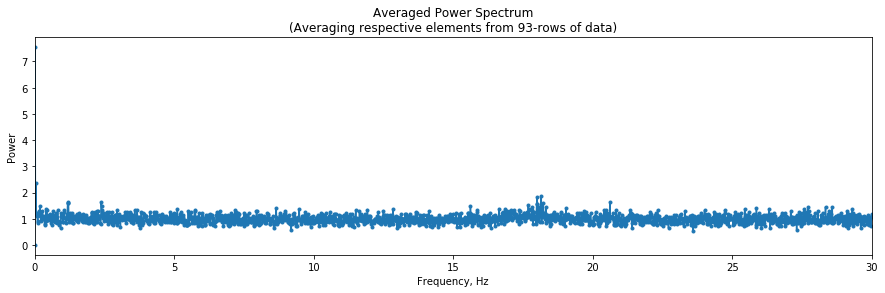

#1 Frequency: 0.0150 Hz
#2 Frequency: 0.0450 Hz
#3 Frequency: 18.1500 Hz
#4 Frequency: 18.0000 Hz
#5 Frequency: 20.6100 Hz


In [4]:
####### Superimpose the power spectra of the independent experiments, and plot them together

superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
superimposed_frequencies = results_list[0].frequencies
for result in results_list:
    for index in range(len(superimposed_power_spectrum)):
        power = result.pspepo_power_spectrum[0,0,1,:][index]
        superimposed_power_spectrum[index] += power
#here I'm dividing the superimposed power by the number of experiments to get an average
average = True
if average:
    superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
    print("!!!!!! Power is averaged here! Previous saved versions just have the powers summed!")
        
fig = plt.figure(figsize=(15,4))
plt.plot(superimposed_frequencies, superimposed_power_spectrum,ls="solid",marker='.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((0,superimposed_frequencies[-1]))
if average:
    plt.title("Averaged Power Spectrum\n(Averaging respective elements from {}-rows of data)".format(num_experiments))
else:
    plt.title("Superimposed Power Spectrum\n(Summing respective elements from {}-rows of data)".format(num_experiments))
if save: plt.savefig(base  + name + "_Superimposed_Independent_Experiments" + ".png")
plt.show()

#analyze the frequency-power spectrum
grouped = []
for i in range(len(superimposed_frequencies)):
    grouped.append((superimposed_frequencies[i], superimposed_power_spectrum[i]))
sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
num_points = 5
for i in range(num_points):
    print("#{} Frequency: {:.4f} Hz".format(i+1, sorted_groups[i][0]))

if save == True:
    with open(base+name+"_Superimposed_Data.txt", "w") as file:
        for index in range(len(superimposed_frequencies)):
            f = superimposed_frequencies[index]
            p = superimposed_power_spectrum[index]
            file.write("{}\t{}\n".format(f,p))

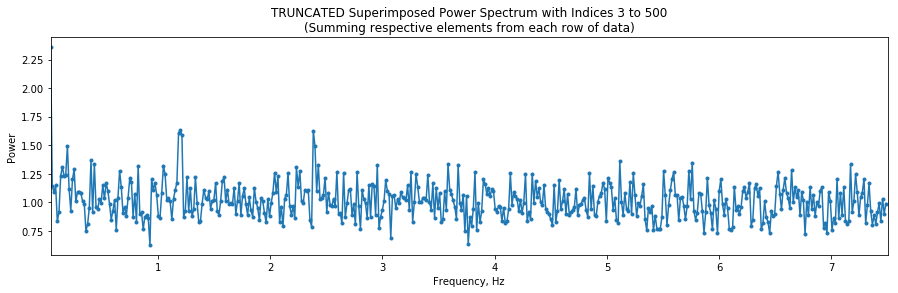

In [5]:
################ This is another area for truncating the superimposed spectrum to frequencies of interest
mindex = 3
maxdex = 500#len(superimposed_frequencies) - 1

fig = plt.figure(figsize=(15,4))
plt.plot(superimposed_frequencies[mindex:maxdex], superimposed_power_spectrum[mindex:maxdex],ls="solid",marker='.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((superimposed_frequencies[mindex],superimposed_frequencies[maxdex]))
plt.title("TRUNCATED Superimposed Power Spectrum with Indices {} to {}\n(Summing respective elements from each row of data)".format(mindex, maxdex))
plt.show()

In [23]:
##### Do 3D optimization here across the number of experiments

#specify indices of lines you want to test
experiment_indices = np.arange(0, 6)
form='sine'
f_range=np.linspace(1.19, 1.255, 40)
a_range=np.linspace(0.02, 0.045, 15)
p_range=np.linspace(0, 2*np.pi, 14)

if True:
    from max_likelihood import three_dimensional_optimization, p1_sine, p0_sine
    threeD_opt_params_list = []
    for exp_index in experiment_indices:
        print("On experiment {} out of {}".format(exp_index + 1, len(experiment_indices)))
        ones_count_array, zeros_count_array, timestamp_array = experiments[exp_index]
        losses, opt_prob, opt_params = three_dimensional_optimization(timestamp_array, ones_count_array,
                                                                      f_range, a_range, p_range, form=form, verbose=False)
        threeD_opt_params_list.append(opt_params)
        print(opt_params)
        
    threeD_f_list = [threeD_opt_params_list[i][0] for i in range(len(threeD_opt_params_list))]
    threeD_a_list = [threeD_opt_params_list[i][1] for i in range(len(threeD_opt_params_list))]
    threeD_p_list = [threeD_opt_params_list[i][2] for i in range(len(threeD_opt_params_list))]

    mean_threeD_f = np.mean(np.asarray(threeD_f_list))
    sigma_threeD_f = np.std(np.asarray(threeD_f_list))
    mean_threeD_a = np.mean(np.asarray(threeD_a_list))
    sigma_threeD_a = np.std(np.asarray(threeD_a_list))
    print("Using {} experiments:".format(len(experiment_indices)))
    print("Frequency mean: {:.3f} +- {:.3f} Hz".format(mean_threeD_f, sigma_threeD_f))
    print("Amplitude mean: {:.3f} +- {:.3f}".format(mean_threeD_a, sigma_threeD_a))


On experiment 1 out of 6
(1.1933333333333334, 0.045, 3.383253626942854)
On experiment 2 out of 6
(1.2233333333333332, 0.04321428571428572, 0.0)
On experiment 3 out of 6
(1.1966666666666665, 0.045, 6.283185307179586)
On experiment 4 out of 6
(1.19, 0.0325, 2.41660973353061)
On experiment 5 out of 6
(1.2083333333333333, 0.0325, 2.41660973353061)
On experiment 6 out of 6
(1.1933333333333334, 0.030714285714285715, 5.799863360473464)
Using 6 experiments:
Frequency mean: 1.201 +- 0.012 Hz
Amplitude mean: 0.038 +- 0.006


In [36]:
########### Use the scipy optimization here. To work, it requires a good guess in guess_params

#specify the indices of the lines you want to test
experiment_indices = np.arange(0, num_experiments)
form = 'sine'
guess_params = (1.2, 0.03, 0)

if True:
    from max_likelihood import three_dimensional_optimization, p1_sine, p0_sine
    scipy_opt_params_list = []
    for exp_index in experiment_indices:
        ones_count_array, zeros_count_array, timestamp_array = experiments[exp_index]
        from max_likelihood import scipy_optimization
        opt_params = scipy_optimization(timestamp_array, ones_count_array, guess_params, form, plot=False, actual_params=None)
        scipy_opt_params_list.append(opt_params)
        print(opt_params)
        
    scipy_f_list = [scipy_opt_params_list[i][0] for i in range(len(scipy_opt_params_list))]
    scipy_a_list = [scipy_opt_params_list[i][1] for i in range(len(scipy_opt_params_list))]
    scipy_p_list = [scipy_opt_params_list[i][2] for i in range(len(scipy_opt_params_list))]

    mean_scipy_f = np.mean(np.asarray(scipy_f_list))
    sigma_scipy_f = np.std(np.asarray(scipy_f_list))
    mean_scipy_a = np.mean(np.asarray(scipy_a_list))
    sigma_scipy_a = np.std(np.asarray(scipy_a_list))
    print("Using {} experiments:".format(len(experiment_indices)))
    print("Frequency mean: {:.3f} +- {:.3f} Hz".format(mean_scipy_f, sigma_scipy_f))
    print("Amplitude mean: {:.3f} +- {:.3f}".format(mean_scipy_a, sigma_scipy_a))

[1.25348870e+00 2.95828294e-02 7.53657933e-05]
[ 1.22389896  0.04371159 -0.00419705]
[ 1.19639334  0.04961305 -0.00224546]
[ 1.20414541e+00  1.65580905e-02 -5.07410225e-05]
[1.38477691e+00 2.12502385e-02 2.40599367e-04]
[ 1.12875601e+00  3.72282435e-02 -4.27818787e-04]
[1.20486374e+00 4.06124927e-02 2.57333972e-04]
[ 1.21001600e+00  3.79780161e-02 -3.73585084e-04]
[ 1.23973524  0.02128669 -0.0031877 ]
[1.29383896 0.03677665 0.00193776]
[ 1.14013450e+00  2.38784849e-02 -2.77519855e-04]
[ 1.23281961  0.00926414 -0.00210192]
[ 1.27178554e+00  2.07877157e-02 -1.11186368e-03]
[ 1.18493876e+00  2.86889896e-02 -1.07712945e-05]
[ 1.20131654e+00  3.74142978e-02 -1.88160507e-04]
[ 1.31050824e+00  3.02129994e-02 -1.11040623e-04]
[1.13228710e+00 2.78211290e-02 3.91168853e-04]
[ 1.27985616  0.03672347 -0.00133263]
[1.26254317e+00 1.68546210e-02 4.10809288e-04]
[1.22537001e+00 3.02025390e-02 4.40106289e-05]
[ 1.30787646  0.0367207  -0.0018529 ]
[ 1.24686299  0.02327082 -0.00253922]
[ 1.19142296  0.0

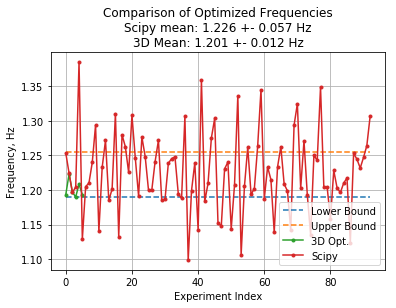

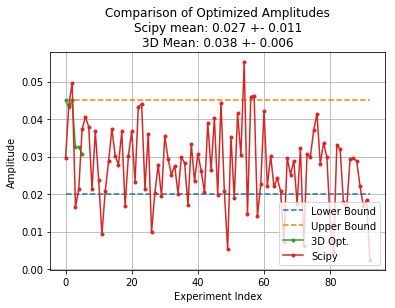

In [37]:
####### Compare the two optimization methods here
plt.plot([f_range[0]]*len(scipy_f_list), ls='dashed', label='Lower Bound')
plt.plot([f_range[-1]]*len(scipy_f_list), ls='dashed', label='Upper Bound')
plt.plot(threeD_f_list, label="3D Opt.", marker='.')
plt.plot(scipy_f_list, label="Scipy", marker='.')
plt.xlabel("Experiment Index")
plt.ylabel("Frequency, Hz")
plt.title("Comparison of Optimized Frequencies\nScipy mean: {:.3f} +- {:.3f} Hz\n3D Mean: {:.3f} +- {:.3f} Hz".format(
    mean_scipy_f, sigma_scipy_f, mean_threeD_f, sigma_threeD_f))
plt.grid()
plt.legend(loc='lower right')
plt.show()


plt.plot([a_range[0]]*len(scipy_a_list), ls='dashed', label='Lower Bound')
plt.plot([a_range[-1]]*len(scipy_a_list), ls='dashed', label='Upper Bound')
plt.plot(threeD_a_list, label="3D Opt.", marker='.')
plt.plot(scipy_a_list, label="Scipy", marker='.')
plt.xlabel("Experiment Index")
plt.ylabel("Amplitude")
plt.title("Comparison of Optimized Amplitudes\nScipy mean: {:.3f} +- {:.3f}\n3D Mean: {:.3f} +- {:.3f}".format(
    mean_scipy_a, sigma_scipy_a, mean_threeD_a, sigma_threeD_a))
plt.grid()
plt.legend(loc='lower right')
plt.show()